In [120]:
# import libraries

# handle dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression,LinearRegression, Lasso, Ridge
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


from tabulate import tabulate

from sklearn import linear_model

from imblearn.over_sampling import SMOTE
# if there is an error, solve by downgrading to install scikit-learn==1.2.2 
# ''' steps : 
# 1. install pip 
# 2. uninstall sci-kit 
# 3. uninstall imblearn
# 4. install sci-kit 1.2.2 
# 5. install imblearn 
# '''


# Data set from https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data

In [121]:
# split train test dataset 

df = pd.read_csv('Loan_Default.csv')
# remove some variables that are redundant 
# year, ID
# Interest_rate_spread and rate_of_interest are dropped due to the fact that their values are NA where the loan has defaulted 
# open credit , secured by, total units : only has one value or too few observations 
df = df.drop(['year', 'ID', 'loan_type', 'loan_purpose', 'Interest_rate_spread', 
              'rate_of_interest', 'open_credit','Upfront_charges','construction_type', 
              'Secured_by', 'Security_Type','total_units'], axis=1)
# print(df['Status'].value_counts())
# print(df.isna().sum())

# Assumption 2 : We focus on mortgage loans 
df = df.dropna(subset=["property_value"])
# Assumption 3 : drop approv in adv that is NA (only small set of samples)
df = df.dropna(subset=["term"])
df = df.dropna(subset=["loan_limit"])
df = df.dropna(subset=["approv_in_adv"])
df = df.dropna(subset=["Neg_ammortization"])
df = df.dropna(subset=["income"])
# Drop rows where sex is not available 
df = df.drop(df[df['Gender'] == 'Not Available'].index)


print("Number of rows : " , len(df.index))
# LTV = Loan to Value -> compares the loan value to the value of the asset being purchased as a part of the loan 
# Property Value 

print(df.columns)
print(df['Status'].value_counts())

      


Number of rows :  120635
Index(['loan_limit', 'Gender', 'approv_in_adv', 'Credit_Worthiness',
       'business_or_commercial', 'loan_amount', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value', 'occupancy_type',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Status', 'dtir1'],
      dtype='object')
Status
0    100978
1     19657
Name: count, dtype: int64


In [122]:
df.isna().value_counts()

loan_limit  Gender  approv_in_adv  Credit_Worthiness  business_or_commercial  loan_amount  term   Neg_ammortization  interest_only  lump_sum_payment  property_value  occupancy_type  income  credit_type  Credit_Score  co-applicant_credit_type  age    submission_of_application  LTV    Region  Status  dtir1
False       False   False          False              False                   False        False  False              False          False             False           False           False   False        False         False                     False  False                      False  False   False   False    120635
Name: count, dtype: int64

In [123]:
# print(df['Neg_ammortization'].head())

# for column_name in df.columns:
#     # Count the number of NA values in the current column
#     na_count = df[column_name].isna().sum()
#     if na_count > 0 : 
#     # Print the result
#         print(f"The column '{column_name}' has {na_count} NA values.")

# print(df.columns)
print(df['loan_limit'].value_counts())


loan_limit
cf     112768
ncf      7867
Name: count, dtype: int64


In [124]:

categorical_columns = ['loan_limit', 'Gender', 'approv_in_adv', 'Credit_Worthiness',
       'business_or_commercial', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'occupancy_type',
        'credit_type', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'Region']

for i in categorical_columns: 
    df = pd.concat([df,pd.get_dummies(df[i],drop_first=True, prefix=i)],axis=1)
    df = df.drop(i,axis=1)


# Checking Correlation between values 

In [125]:
correlation_matrix = df.corr()

# Exclude diagonal elements
correlation_matrix_no_diagonal = correlation_matrix.mask(
    pd.DataFrame(np.eye(len(correlation_matrix), dtype=bool), correlation_matrix.index, correlation_matrix.columns))

# Display the correlation matrix without diagonal elements
print("Correlation Matrix (excluding diagonal):")
print(correlation_matrix_no_diagonal)

# Check for high absolute correlation coefficients
threshold = 0.8  # You can adjust this threshold based on your criteria
highly_correlated_pairs = []

for i in range(len(correlation_matrix_no_diagonal.columns)):
    for j in range(i):
        correlation = correlation_matrix_no_diagonal.iloc[i, j]
        if abs(correlation) > threshold:
            pair = (correlation_matrix_no_diagonal.columns[i], correlation_matrix_no_diagonal.index[j], correlation)
            highly_correlated_pairs.append(pair)

if highly_correlated_pairs:
    print("\nHighly correlated pairs:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]}")
else:
    print("\nNo highly correlated pairs found.")

Correlation Matrix (excluding diagonal):
                                   loan_amount      term  property_value  \
loan_amount                                NaN  0.174069        0.734557   
term                                  0.174069       NaN        0.048861   
property_value                        0.734557  0.048861             NaN   
income                                0.451717 -0.054883        0.415447   
Credit_Score                          0.005377 -0.002933        0.003639   
LTV                                   0.063775  0.209505       -0.442754   
Status                               -0.039615  0.008818       -0.045619   
dtir1                                 0.014500  0.111253       -0.056722   
loan_limit_ncf                        0.258006  0.015988        0.200278   
Gender_Joint                          0.190145  0.021610        0.156026   
Gender_Male                           0.000939  0.010377       -0.028914   
Gender_Sex Not Available             -0.118203 

In [126]:
if highly_correlated_pairs:
    print("\nHighly correlated pairs:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]}")
else:
    print("\nNo highly correlated pairs found.")


No highly correlated pairs found.


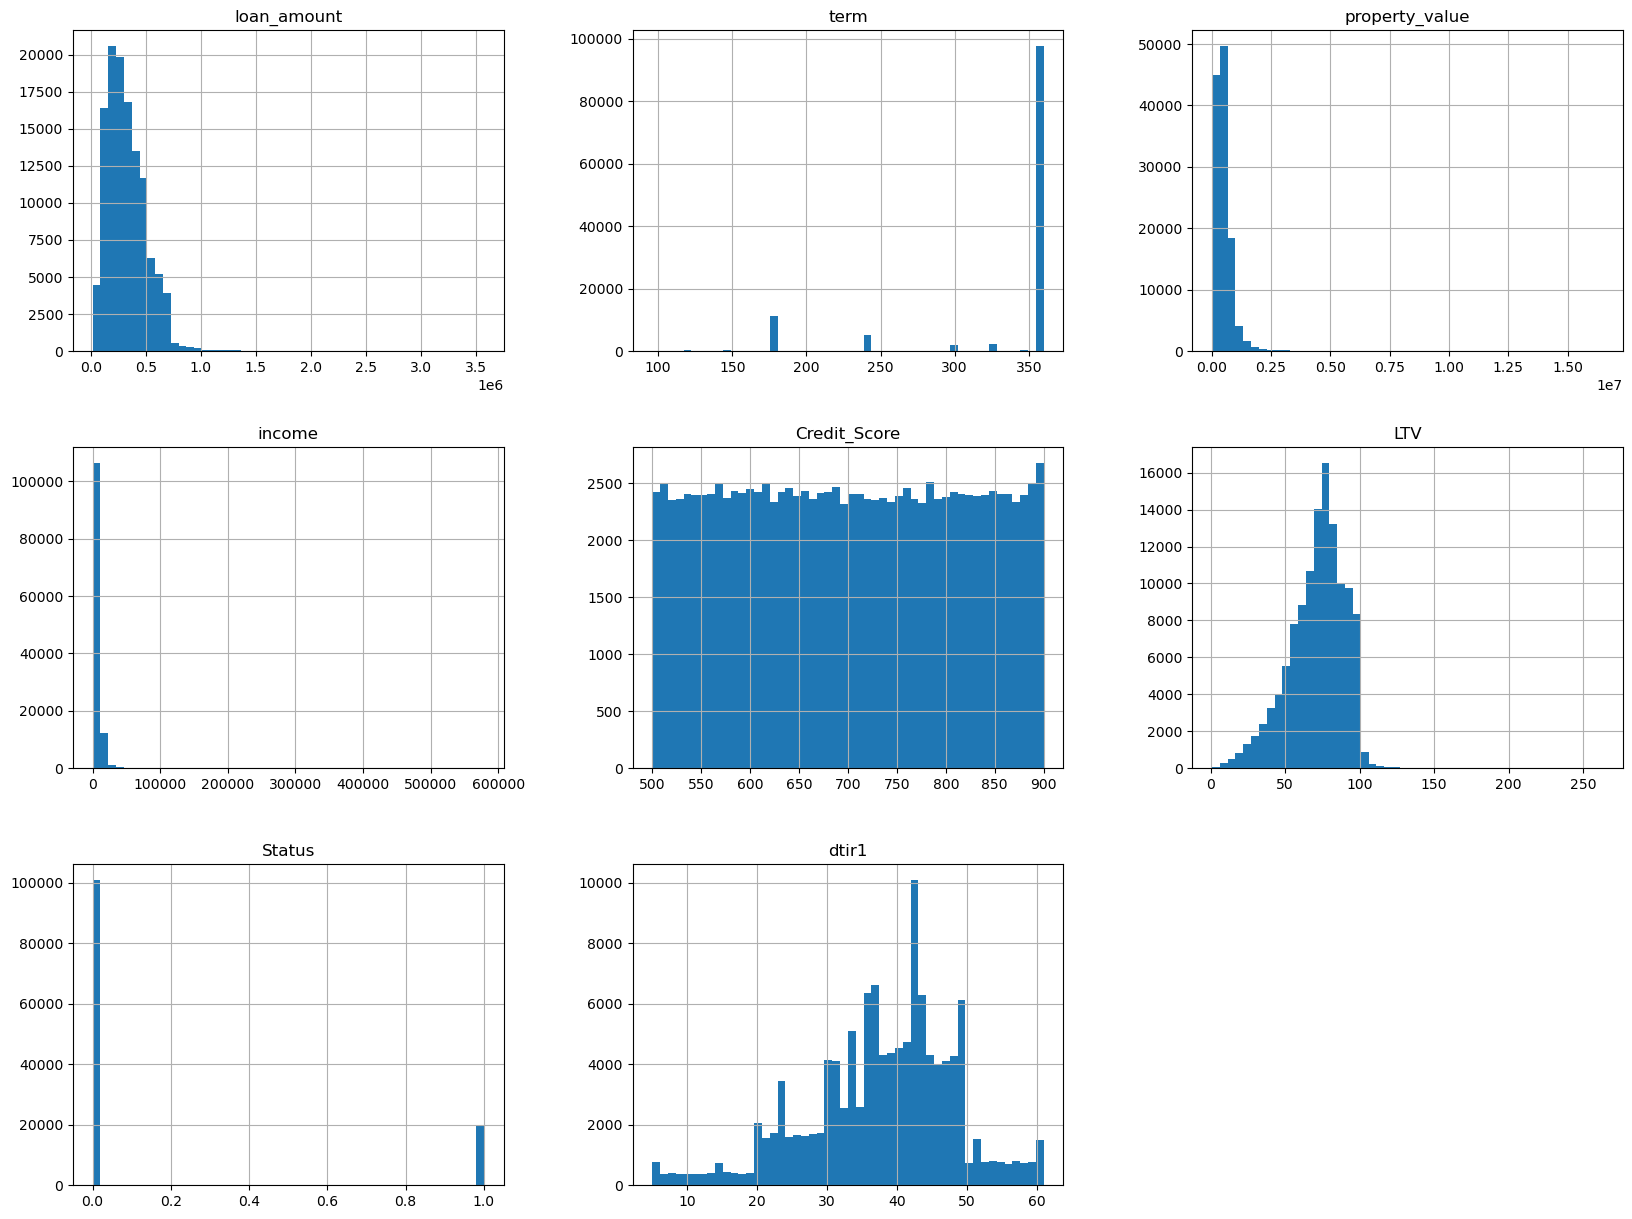

In [127]:
df.hist(bins = 50, figsize = (20, 15))
plt.show()

# Split Train Test dataset

So by looking at the data, we see there are two main types of loans : property loan and non-property loan. 


In [128]:
# define X and y variables as dataframe 
y = df['Status']
X = df.drop('Status',axis=1)
X_train, X_OOS_test, y_train, y_OOS_test = train_test_split(X, y, test_size=0.20, random_state=66)

In [13]:
# non_numeric_columns = X_train.select_dtypes(exclude=['float64', 'int64']).columns
# print("Non-numeric columns:", non_numeric_columns)

## Normalising the values 

In [56]:

# Normalised the values 
scaler = StandardScaler()
# Fit and apply normalization on the training set
X_train = scaler.fit_transform(X_train)
# Apply the same normalization rules on the test set
X_OOS_test = scaler.transform(X_OOS_test)


## Over Sampling 


In [129]:
# Over sample using SMOTE
# -- by inspecting the data, we see that the minority class is extremely class (fraud "Class" == 1)
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [130]:
# -- Code to Inspect the data set -- 
# df_oversampled = X_smote
# df_oversampled['Outcome_Variable'] = y_smote
# df_oversampled
# fig, ax = plt.subplots(figsize=(10, 8))
# df_oversampled['Outcome_Variable'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
# ax.set_title('Oversampled Dataset', fontsize=16)
# ax.set_ylabel('Observation counts', fontsize=14)
# ax.set_xlabel('Class', fontsize=14)
# plt.show()

print(y_smote.value_counts())


Status
0    80809
1    80809
Name: count, dtype: int64


In [131]:
# Set up K-Fold Cross Validation 
n_splits = 5
shuffle = True
random_state = 809
cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
# plot = plot_cv_indices(cv, X_smote, y_smote, n_splits)

## Model 1 : Logistic Regression 

In [151]:
def plot_cv_indices(cv, X, y, n_splits, lw=10):
    '''
    This function plots the Cross validation indices.
    '''
    
    fig, ax = plt.subplots(figsize = (15,8))
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['Class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [152]:
model = LogisticRegression(solver='lbfgs', max_iter=300)
model.fit(X_smote, y_smote)    
score_OOS = model.score(X_OOS_test, y_OOS_test)
print ("Logistic Model score :" , score_OOS)
y_pred = model.predict(X_OOS_test)
print("Logistic Model Recall : " , recall_score(y_OOS_test, y_pred))
print("Logistic Model Precision : ", precision_score(y_OOS_test,y_pred))
print("Probability if you only predict 0s ", 1-round(95/56867,3))

Logistic Model score : 0.5554772661333776
Logistic Model Recall :  0.6205154118241536
Logistic Model Precision :  0.21029197705282987
Probability if you only predict 0s  0.998


/Users/norawang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(




# Model 2 : Lasso 

## Cross Validation for LASSO 

In [135]:
# Model 2 : LASSO 
# Cross Validate the penalty term in lasso
cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
lambdas = [0.001, 0.0025, 0.005, 0.0075,0.01, 0.0125, 0.015, 0.0175,0.02]
for lambda_value in lambdas:
    print('Training Lasso Lambda Value : ', lambda_value)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    lasso = linear_model.Lasso(alpha=lambda_value)
    for train_index, test_index in cv.split(X_smote):
        # change to loc to define the rows in the dataframe 
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
        lasso.fit(X_cv_train, y_cv_train)
        y_pred = lasso.predict(X_cv_test)
        y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]

        #Cross-Validation Prediction Error
        score = lasso.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred_classification))
        precision_scores.append(precision_score(y_cv_test,y_pred_classification))

    cross_validate_result[lambda_value] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[lambda_value] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[lambda_value] = (sum(precision_scores)/len(precision_scores))

    print("Lambda Value Accuracy : " + str(lambda_value) + " " + str((sum(accuracies)/len(accuracies))))
    print("Lambda Value Precision : " + str(lambda_value) + " " + str((sum(recall_scores)/len(recall_scores))))
    print("Lambda Value Recall : " + str(lambda_value) + " " + str((sum(precision_scores)/len(precision_scores))))
    print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)



    

Training Lasso Lambda Value :  0.001
Lambda Value Accuracy : 0.001 0.44711725719929485
Lambda Value Precision : 0.001 0.7694027479516002
Lambda Value Recall : 0.001 0.8703847008502779

Training Lasso Lambda Value :  0.0025
Lambda Value Accuracy : 0.0025 0.43852200006548847
Lambda Value Precision : 0.0025 0.7704361990358108
Lambda Value Recall : 0.0025 0.8580079276109858

Training Lasso Lambda Value :  0.005
Lambda Value Accuracy : 0.005 0.4239234748471895
Lambda Value Precision : 0.005 0.7731679147348525
Lambda Value Recall : 0.005 0.8412426886210259

Training Lasso Lambda Value :  0.0075
Lambda Value Accuracy : 0.0075 0.40865517205749463
Lambda Value Precision : 0.0075 0.7784884785769004
Lambda Value Recall : 0.0075 0.8281218854352526

Training Lasso Lambda Value :  0.01
Lambda Value Accuracy : 0.01 0.38834371860427935
Lambda Value Precision : 0.01 0.7797380844218446
Lambda Value Recall : 0.01 0.8130769483463176

Training Lasso Lambda Value :  0.0125
Lambda Value Accuracy : 0.0125 0.3

# LASSO precision recall graph

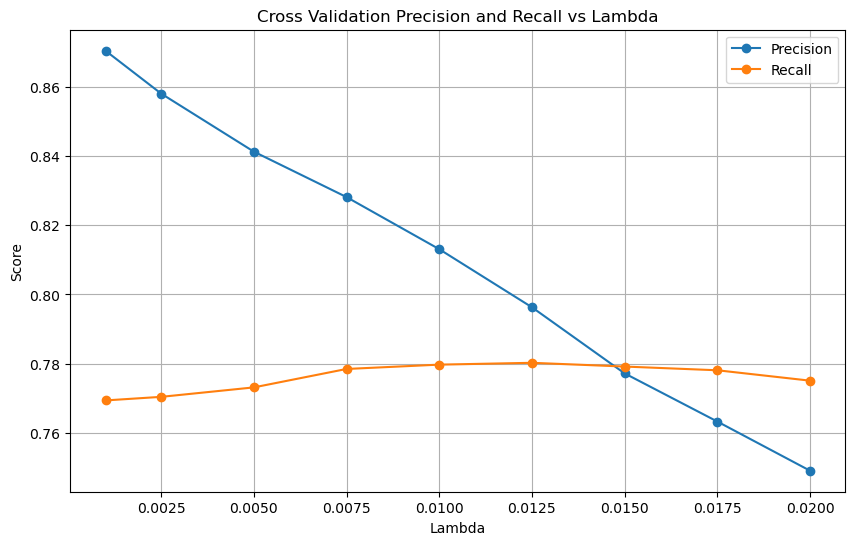

In [136]:
# Precision and Recall line graph
plt.figure(figsize=(10, 6))

for metric, scores in zip(['Precision', 'Recall'], [cross_validate_precision, cross_validate_recall]):
    lambda_values = sorted(scores.keys())
    score_values = [scores[lambda_value] for lambda_value in lambda_values]
    plt.plot(lambda_values, score_values, marker='o', label=f'{metric}')

plt.title('Cross Validation Precision and Recall vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [155]:
column_names = df.drop('Status', axis=1).columns
print(column_names)

Index(['loan_amount', 'term', 'property_value', 'income', 'Credit_Score',
       'LTV', 'dtir1', 'loan_limit_ncf', 'Gender_Joint', 'Gender_Male',
       'Gender_Sex Not Available', 'approv_in_adv_pre', 'Credit_Worthiness_l2',
       'business_or_commercial_nob/c', 'Neg_ammortization_not_neg',
       'interest_only_not_int', 'lump_sum_payment_not_lpsm',
       'occupancy_type_pr', 'occupancy_type_sr', 'credit_type_CRIF',
       'credit_type_EQUI', 'credit_type_EXP', 'co-applicant_credit_type_EXP',
       'age_35-44', 'age_45-54', 'age_55-64', 'age_65-74', 'age_<25',
       'age_>74', 'submission_of_application_to_inst', 'Region_North-East',
       'Region_central', 'Region_south'],
      dtype='object')


In [157]:
# LASSO 
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_smote, y_smote)
y_pred = lasso.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("LASSO score : " , )
print("LASSO Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("LASSO Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

LASSO score : 
LASSO Model Recall :  0.32289034866093985
LASSO Model Precision :  0.26366824840107284
--


In [158]:
print(lasso.coef_)
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        print(column_names[i], ' : ' , lasso.coef_[i])

[-1.29232361e-07  1.73262260e-04  1.37910617e-07 -5.06631398e-06
  1.50930141e-05  3.83157826e-03  2.85340560e-03  1.62569845e-02
  1.10647240e-01  1.84757095e-01  8.71763271e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.17000740e-01
  0.00000000e+00  1.11856991e-01  0.00000000e+00  1.57051748e-01
  1.94534911e-01  2.13174936e-01  1.85774697e-01  0.00000000e+00
  1.21677168e-01  1.83605336e-01  0.00000000e+00  2.77965882e-02
  1.10558995e-01]
loan_amount  :  -1.2923236143146565e-07
term  :  0.0001732622598189971
property_value  :  1.3791061722216492e-07
income  :  -5.066313975150981e-06
Credit_Score  :  1.5093014119256553e-05
LTV  :  0.003831578263956499
dtir1  :  0.0028534056031997036
loan_limit_ncf  :  0.016256984546071333
Gender_Joint  :  0.11064723961314146
Gender_Male  :  0.18475709461522968
Gender_Sex Not Available  :  0.08717632706677085
credit_type_CRIF  :  0.11700074020462602
credit_type

# Ridge cross validation

In [145]:
# Cross Validate the Ridge regression
cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

# Set Hyperparameter (Alpha) values to cross validate
alphas = [0.1, 1,3, 5, 10]
for alpha_value in alphas:
    print('Training Ridge Alpha value:', alpha_value)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    ridge = Ridge(alpha=alpha_value)
    for train_index, test_index in cv.split(X_smote):
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
        ridge.fit(X_cv_train, y_cv_train)
        y_pred = ridge.predict(X_cv_test)
        y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]

        # Cross-Validation Prediction Error
        score = ridge.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred_classification))
        precision_scores.append(precision_score(y_cv_test, y_pred_classification))

    cross_validate_result[alpha_value] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[alpha_value] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[alpha_value] = (sum(precision_scores)/len(precision_scores))

    print("Alpha Value Accuracy:", cross_validate_result[alpha_value])
    print("Alpha Value Precision:", cross_validate_precision[alpha_value])
    print("Alpha Value Recall:", cross_validate_recall[alpha_value])
    print() 

# At the end you'll see what the value of each Ridge parameter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ', cross_validate_precision)
print('Recall : ', cross_validate_recall)
print(max(cross_validate_result, key=cross_validate_result.get))
print(max(cross_validate_precision, key=cross_validate_precision.get))
print(max(cross_validate_recall, key=cross_validate_recall.get))

Training Ridge Alpha value: 0.1
Alpha Value Accuracy: 0.4492235064464675
Alpha Value Precision: 0.8770218956562509
Alpha Value Recall: 0.7670639219983653

Training Ridge Alpha value: 1
Alpha Value Accuracy: 0.4492240601532093
Alpha Value Precision: 0.8769987450795
Alpha Value Recall: 0.7670762190962501

Training Ridge Alpha value: 3
Alpha Value Accuracy: 0.44922472123976076
Alpha Value Precision: 0.8770127731145066
Alpha Value Recall: 0.7670884378202052

Training Ridge Alpha value: 5
Alpha Value Accuracy: 0.44922497789685895
Alpha Value Precision: 0.876995065027474
Alpha Value Recall: 0.7670512122458006

Training Ridge Alpha value: 10
Alpha Value Accuracy: 0.4492248439285049
Alpha Value Precision: 0.8768490907432787
Alpha Value Recall: 0.7670758140547332

------------------
Accuracy :  {0.1: 0.4492235064464675, 1: 0.4492240601532093, 3: 0.44922472123976076, 5: 0.44922497789685895, 10: 0.4492248439285049}
Precision :  {0.1: 0.8770218956562509, 1: 0.8769987450795, 3: 0.8770127731145066, 

# Ridge graph

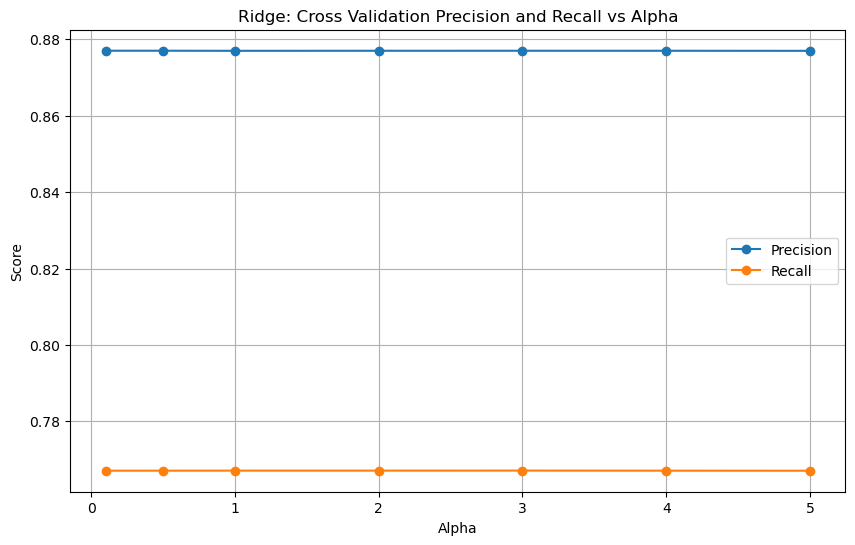

In [142]:
# Precision and Recall line graph
plt.figure(figsize=(10, 6))

for metric, scores in zip(['Precision', 'Recall'], [cross_validate_precision, cross_validate_recall]):
    alpha_values = sorted(scores.keys())
    score_values = [scores[alpha_value] for alpha_value in alpha_values]
    plt.plot(alpha_values, score_values, marker='o', label=f'{metric}')

plt.title('Ridge: Cross Validation Precision and Recall vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# OLS cross validation

In [ ]:
# Cross Validate the OLS regression
cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

# Set Hyperparameter (None for OLS)
hyperparameters = [None]  # OLS doesn't have hyperparameters, so we use None
for hyperparameter in hyperparameters:
    print('Training OLS')
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    ols = LinearRegression()
    for train_index, test_index in cv.split(X_smote):
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
        ols.fit(X_cv_train, y_cv_train)
        y_pred = ols.predict(X_cv_test)
        y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]

        # Cross-Validation Prediction Error
        score = ols.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred_classification))
        precision_scores.append(precision_score(y_cv_test, y_pred_classification))

    cross_validate_result[hyperparameter] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[hyperparameter] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[hyperparameter] = (sum(precision_scores)/len(precision_scores))

    print("Accuracy: ", cross_validate_result[hyperparameter])
    print("Precision: ", cross_validate_precision[hyperparameter])
    print("Recall: ", cross_validate_recall[hyperparameter])
    print() 

# At the end you'll see what the value of each OLS parameter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ', cross_validate_precision)
print('Recall : ', cross_validate_recall)

# Cross Validate LASSO, OLS, and Ridge

In [148]:
# Cross Validate LASSO, OLS, and Ridge
models = {
    "LASSO": Lasso,
    "OLS": LinearRegression,
    "Ridge": Ridge
}

# Set hyperparameters for LASSO and Ridge
lasso_alphas = [0.01]
ridge_alphas = [3]

# Store cross-validation results
cross_validate_results = {model_name: {} for model_name in models.keys()}
cross_validate_recalls = {model_name: {} for model_name in models.keys()}
cross_validate_precisions = {model_name: {} for model_name in models.keys()}

for model_name, model_class in models.items():
    print(f"Training {model_name}")
    hyperparameters = lasso_alphas if model_name == "LASSO" else ridge_alphas if model_name == "Ridge" else [None]
    for hyperparameter in hyperparameters:
        print(f"{model_name} with Hyperparameter: {hyperparameter}")
        accuracies = []
        recall_scores = []
        precision_scores = []
        model = model_class(alpha=hyperparameter) if hyperparameter is not None else model_class()
        for train_index, test_index in cv.split(X_smote):
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            model.fit(X_cv_train, y_cv_train)
            y_pred = model.predict(X_cv_test)
            y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]

            # Cross-Validation Prediction Error
            score = model.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred_classification))
            precision_scores.append(precision_score(y_cv_test, y_pred_classification))

        cross_validate_results[model_name][hyperparameter] = (sum(accuracies) / len(accuracies))
        cross_validate_recalls[model_name][hyperparameter] = (sum(recall_scores) / len(recall_scores))
        cross_validate_precisions[model_name][hyperparameter] = (sum(precision_scores) / len(precision_scores))

        print(f"{model_name} Accuracy: {cross_validate_results[model_name][hyperparameter]}")
        print(f"{model_name} Precision: {cross_validate_precisions[model_name][hyperparameter]}")
        print(f"{model_name} Recall: {cross_validate_recalls[model_name][hyperparameter]}")
        print()

print('------------------')
print('Accuracy :', cross_validate_results)
print('Precision :', cross_validate_precisions)
print('Recall :', cross_validate_recalls)

Training LASSO
LASSO with Hyperparameter: 0.01
LASSO Accuracy: 0.38834371860427935
LASSO Precision: 0.8130769483463176
LASSO Recall: 0.7797380844218446

Training OLS
OLS with Hyperparameter: None
OLS Accuracy: 0.4492234292659226
OLS Precision: 0.8770218956562509
OLS Recall: 0.7670639219983653

Training Ridge
Ridge with Hyperparameter: 3
Ridge Accuracy: 0.44922472123976076
Ridge Precision: 0.8770127731145066
Ridge Recall: 0.7670884378202052

------------------
Accuracy : {'LASSO': {0.01: 0.38834371860427935}, 'OLS': {None: 0.4492234292659226}, 'Ridge': {3: 0.44922472123976076}}
Precision : {'LASSO': {0.01: 0.8130769483463176}, 'OLS': {None: 0.8770218956562509}, 'Ridge': {3: 0.8770127731145066}}
Recall : {'LASSO': {0.01: 0.7797380844218446}, 'OLS': {None: 0.7670639219983653}, 'Ridge': {3: 0.7670884378202052}}


## LASSO vs Ridge vs OLS

In [150]:
# Somehow LASSO is performing worse?
ols = linear_model.LinearRegression()
ols.fit(X_smote, y_smote)    
y_pred = ols.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("OLS Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("OLS Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# LASSO 
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_smote, y_smote)
y_pred = lasso.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("LASSO score : " , )
print("LASSO Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("LASSO Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# RIDGE
ridge = linear_model.Ridge(alpha=3)
ridge.fit(X_smote, y_smote)
y_pred = ridge.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("Ridge Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("Ridge Model Precision : ", precision_score(y_OOS_test,y_pred_classification))

OLS Model Recall :  0.2594744820616473
OLS Model Precision :  0.32407699589775957
--
LASSO score : 
LASSO Model Recall :  0.32289034866093985
LASSO Model Precision :  0.26366824840107284
--
Ridge Model Recall :  0.2594744820616473
Ridge Model Precision :  0.32397476340694004


# Random Forest

In [128]:

random_forest = RandomForestClassifier(n_estimators = 50, max_depth=2, random_state=0)
random_forest.fit(X_smote, y_smote)

y_pred = random_forest.predict(X_OOS_test)
print("RND Forest Model Recall : " , recall_score(y_OOS_test, y_pred))
print("RND Forest Precision : ", precision_score(y_OOS_test,y_pred))

RND Forest Model Recall :  0.41611925214754925
RND Forest Precision :  0.28455425017277125


In [ ]:
# Cross Validate Random Forest
param_grid = [{'n_estimators': [200,225,250], 'max_depth' :[10,20,30]}]
random_forest_cv = RandomForestClassifier()
grid_cv = GridSearchCV(estimator=random_forest_cv, cv=cv, param_grid=param_grid, n_jobs = 3)
grid_cv.fit(X_smote, y_smote)

In [28]:
def create_dictionary(param_1,param_2):
    result_dictionary = {} 
    for i in param_1: 
        result_dictionary[i] = {} 
        for j in param_2: 
                result_dictionary[i][j] = {} 
    return result_dictionary


### Random Forest Cross Validation

In [40]:
# CV in Trees  
# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
max_depth = [2, 3, 4]
number_of_trees = [5,10,15] 

cross_validate_result = create_dictionary(number_of_trees,max_depth)
cross_validate_recall = create_dictionary(number_of_trees,max_depth)
cross_validate_precision = create_dictionary(number_of_trees,max_depth) 

for tree in number_of_trees: 
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Number of Trees ', tree)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        random_forest_cv = RandomForestClassifier(n_estimators = tree, max_depth=depth)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            random_forest_cv.fit(X_cv_train, y_cv_train)
            y_pred = random_forest_cv.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = random_forest_cv.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[tree][depth] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[tree][depth] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[tree][depth] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

# KNN 

In [22]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_smote, y_smote)
# Make predictions on the test data
y_pred = knn.predict(X_OOS_test)
# Evaluate the accuracy of the classifier
print("KNN Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("KNN Recall : " , recall_score(y_OOS_test, y_pred))
print("KNN Precision : ", precision_score(y_OOS_test,y_pred))

KNN Accuracy :  0.6375430016164463
KNN Recall :  0.4373420919656392
KNN Precision :  0.20984361740817067


## Cross Validation for KNN 

In [42]:
# CV in Trees 
# Set Hyperparameter (Lambda) values to cross validate here !!!!!
number_of_neighbours = [1,2,3] 

cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

for neighbour in number_of_neighbours: 
    print('Number of Neighbours : ', neighbour)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    knn = KNeighborsClassifier(n_neighbors=neighbour)
    for train_index, test_index in cv.split(X_smote):
        # change to loc to define the rows in the dataframe 
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
        knn.fit(X_cv_train, y_cv_train)
        y_pred = knn.predict(X_cv_test)

        #Cross-Validation Prediction Error
        score = knn.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred))
        precision_scores.append(precision_score(y_cv_test,y_pred))
    
    cross_validate_result[neighbour] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[neighbour] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[neighbour] = (sum(precision_scores)/len(precision_scores))

    print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
    print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
    print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
    print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Number of Neighbours :  1
Accuracy : 0.7491306930716343
Precision : 0.7913814929899982
Recall : 0.7297182708745649

Number of Neighbours :  2
Accuracy : 0.7208912490896946
Precision : 0.6143489063987174
Recall : 0.7807035859110011

Number of Neighbours :  3
Accuracy : 0.7284461019183828
Precision : 0.7750719833779053
Recall : 0.7089621936913701

------------------
Accuracy :  {1: 0.7491306930716343, 2: 0.7208912490896946, 3: 0.7284461019183828}
Precision :  {1: 0.7297182708745649, 2: 0.7807035859110011, 3: 0.7089621936913701}
Recall :  {1: 0.7913814929899982, 2: 0.6143489063987174, 3: 0.7750719833779053}


# LASSO and Random Forest

In [63]:
# LASSO 
lasso = linear_model.Lasso()
lasso.fit(X_smote, y_smote)
y_pred = lasso.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("LASSO score : " , )
print("LASSO Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("LASSO Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# See LASSO coefficient that is 0 
lasso_coefficients = pd.Series(lasso.coef_)
non_zero_lasso_coefficients = lasso_coefficients[lasso_coefficients != 0]
# Print the non-zero coefficients
print("Non-zero Lasso Coefficients:")
print(non_zero_lasso_coefficients)


LASSO score : 
LASSO Model Recall :  1.0
LASSO Model Precision :  0.1640485762838314
--
Non-zero Lasso Coefficients:
Series([], dtype: float64)


In [48]:
X_lasso_rf_train = X_smote[['loan_amount','property_value','income']]
X_lasso_rf_test = X_OOS_test[['loan_amount','property_value','income']]
random_forest = RandomForestClassifier(n_estimators = 100, max_depth=5, random_state=0)
random_forest.fit(X_lasso_rf_train, y_smote)
y_pred = random_forest.predict(X_lasso_rf_test)
print("RND Forest Model Recall : " , recall_score(y_OOS_test, y_pred))
print("RND Forest Precision : ", precision_score(y_OOS_test,y_pred))

RND Forest Model Recall :  0.6139464375947449
RND Forest Precision :  0.23610571317528178


## Cross Validation for LASSO and randomforest

In [64]:
# CV in Trees  
# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
max_depth = [2, 3, 4]
number_of_trees = [5,10,15] 

cross_validate_result = create_dictionary(number_of_trees,max_depth)
cross_validate_recall = create_dictionary(number_of_trees,max_depth)
cross_validate_precision = create_dictionary(number_of_trees,max_depth) 

for tree in number_of_trees: 
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Number of Trees ', tree)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        random_forest_cv = RandomForestClassifier(n_estimators = tree, max_depth=depth)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_lasso_rf_train.iloc[train_index], X_lasso_rf_train.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            random_forest_cv.fit(X_cv_train, y_cv_train)
            y_pred = random_forest_cv.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = random_forest_cv.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[tree][depth] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[tree][depth] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[tree][depth] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  2  Number of Trees  5
Accuracy : 0.5898970807910194
Precision : 0.5600514433592819
Recall : 0.5960859138716283

Depth of Tree :  3  Number of Trees  5
Accuracy : 0.6028969716073906
Precision : 0.6320289001728526
Recall : 0.5975296460241809

Depth of Tree :  4  Number of Trees  5
Accuracy : 0.6066650987112998
Precision : 0.598612368126647
Recall : 0.6089193795794439

Depth of Tree :  2  Number of Trees  10
Accuracy : 0.5953731298159273
Precision : 0.6041965507061027
Recall : 0.593735225239221

Depth of Tree :  3  Number of Trees  10
Accuracy : 0.6015109811705502
Precision : 0.6334501039068922
Recall : 0.5955423320631559

Depth of Tree :  4  Number of Trees  10
Accuracy : 0.6084904183967266
Precision : 0.6153576420941061
Recall : 0.6072664926564537

Depth of Tree :  2  Number of Trees  15
Accuracy : 0.5956700913690367
Precision : 0.5658451977712038
Recall : 0.6022292393645742

Depth of Tree :  3  Number of Trees  15
Accuracy : 0.603589981948197
Precision : 0.629917915617